<a href="https://colab.research.google.com/github/dcnguyen060899/US-Medical-Insurance-Cost-Analysis-Portfolio/blob/main/US_Medical_Insurance_Cost_Predictive_Modeling_Portfolio_(con't).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost Predictive Modeling:
- In this phase, we transition from insightful analysis to practical implementation. Our goal is to construct a robust predictive model that accurately estimates medical expenses. Leveraging advanced techniques and refined features, we aim to provide a powerful tool for informed decision-making in the realm of healthcare costs. This section marks a critical step towards translating our findings into tangible policy recommendations and interventions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/My Drive/Codecademy/US Medical Insurance Project/Data/insurance.csv'

df = pd.read_csv(file_path)
df_copy = df.copy()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## One Hot Coding

In [ ]:
df = pd.get_dummies(df, columns=['smoker', 'region'])

# df['region_northeast'] = 0

# # Set 'region_northeast' to 1 where the specified conditions are met
# df.loc[(df['region_northwest'] == 0) & (df['region_southeast'] == 0) & (df['region_southwest'] == 0), 'region_northeast'] = 1

In [ ]:
# drop smoker_no column
df = df.drop(columns=['smoker_no'], axis=1)

In [ ]:
# add smoker columns and region back to the dataframe
columns = ['smoker', 'region']

for i in range(2):
  df[columns[i]] = df_copy[columns[i]]


In [ ]:
# create smoker region interaction category feature
df['region_smoker_category'] = df['region'] + ' ' + df['smoker_yes'].apply(lambda x: 'Non-smoker' if x == 0 else 'Smoker')


In [ ]:
# drop smoker and region columns
columns = ['smoker', 'region']
for i in range(2):
  df = df.drop(columns[i], axis=1)

In [ ]:
# one hot coding region smoker category
df = pd.get_dummies(df, columns=['region_smoker_category'])

### Create Cluster Region Smoker

In [ ]:
# Import necessary libraries
from sklearn.cluster import KMeans
import pandas as pd

# Assuming you have a DataFrame 'df' with a column 'region' containing geographical data

# Extract relevant features for clustering
X = df[['region_smoker_category_northeast Non-smoker', 'region_smoker_category_northeast Smoker', \
        'region_smoker_category_northwest Non-smoker', 'region_smoker_category_northwest Smoker', \
        'region_smoker_category_southeast Non-smoker', 	'region_smoker_category_southeast Smoker', \
        'region_smoker_category_southwest Non-smoker', 	'region_smoker_category_southwest Smoker']]

# Choose the number of clusters (K)
k = 8  # You can adjust this based on your analysis and requirements

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Add the cluster labels back to the DataFrame
df['cluster_region_smoker'] = kmeans.labels_



- Cluster 0: southwest non smoker
- Cluster 1: northwest non smoker
- Cluster 2: southeast non smoker
- Cluster 3: northeast non smoker
- Cluster 4: southeast smoker
- Cluster 5: northeast smoker
- Cluster 6: northwest smoker
- Cluster 7: southwest smoker


In [ ]:
columns = ['region_smoker_category_northeast Non-smoker', 'region_smoker_category_northeast Smoker', \
        'region_smoker_category_northwest Non-smoker', 'region_smoker_category_northwest Smoker', \
        'region_smoker_category_southeast Non-smoker', 	'region_smoker_category_southeast Smoker', \
        'region_smoker_category_southwest Non-smoker', 	'region_smoker_category_southwest Smoker']

for i in range(8):
  df = df.drop(columns[i], axis=1)

### Create Health Risk Score

In [ ]:
# Define a function to calculate the Health Risk Score
def calculate_health_risk(row):
    # Define weights for each factor (you can adjust these based on domain knowledge)
    age_weight = 0.135984
    bmi_weight = 0.211895
    smoker_weight = 0.609883
    children_weight = 0.019641

    # Define age groups and their corresponding weights
    if row['age'] < 18:
        age_factor = 0.1
    elif 18 <= row['age'] < 40:
        age_factor = 0.3
    elif 40 <= row['age'] < 65:
        age_factor = 0.5
    else:
        age_factor = 0.7

    # Define BMI categories and their corresponding weights
    if row['bmi'] < 18.5:
        bmi_factor = 0.1
    elif 18.5 <= row['bmi'] < 24.99:
        bmi_factor = 0.3
    elif 24.9 <= row['bmi'] < 29.99:
        bmi_factor = 0.5
    else:
        bmi_factor = 0.7

    # Define children factor (scaled to be between 0 and 1)
    children_factor = row['children'] / 5

    # Calculate the Health Risk Score
    health_risk_score = (
        age_weight * age_factor +
        bmi_weight * bmi_factor +
        smoker_weight * row['smoker_yes'] +
        children_weight * children_factor
    )

    return health_risk_score

# Apply the function to create the Health Risk Score column
df['health_risk_score'] = df.apply(calculate_health_risk, axis=1)


### Create Family Size Feature

In [ ]:
# Create a new column 'family_size'
df['family_size'] = df['children'] + 1  # Add 1 for the individual

# Assuming 'sex' is represented as 'male' and 'female'
# Create a mapping for sex to numerical values
sex_mapping = {'male': 1, 'female': 0}
df['sex_male'] = df['sex'].map(sex_mapping)

# Assuming 1 represents male and 0 represents female
# Family size for male will be the same as for female
df['family_size'] = df['family_size'] * df['sex_male']


df = df.drop(columns=['sex'], axis=1)
df = df.drop(columns=['children'], axis=1)





### Create BMI Category Feature

In [ ]:
import numpy as np
# Define the BMI categories and corresponding labels
bmi_categories = [
    (df['bmi'] < 18.5),          # Underweight
    (df['bmi'] >= 18.5) & (df['bmi'] < 24.99),  # Normal Weight
    (df['bmi'] >= 25) & (df['bmi'] < 29.99),   # Overweight
    (df['bmi'] >= 30)              # Obese
]

# Define labels for the categories
bmi_labels = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']

# Create a new column 'bmi_category' based on the conditions and labels
df['bmi_category'] = np.select(bmi_categories, bmi_labels, default='Unknown')




### Create Interaction Feature

In [ ]:
df['age_smoker'] = df['age'] * df['smoker_yes']

df['bmi_smoker'] = df['bmi'] * df['smoker_yes']


df['age_smoker_bmi'] = df['age'] * df['smoker_yes'] * df['bmi']

df['family_size_smoker'] = df['family_size'] * df['smoker_yes']


df['bmi_category_smoker'] = df['bmi_category'] + ' ' + df['smoker_yes'].apply(lambda x: 'Non-smoker' if x == 0 else 'Smoker')



### Create Cluster Region

In [ ]:
# Import necessary libraries
from sklearn.cluster import KMeans
import pandas as pd

# Assuming you have a DataFrame 'df' with a column 'region' containing geographical data

# Extract relevant features for clustering
X = df[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']]  # Add relevant features here

# Choose the number of clusters (K)
k = 4  # You can adjust this based on your analysis and requirements

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Add the cluster labels back to the DataFrame
df['cluster_region'] = kmeans.labels_



- cluster 0: region_southwest
- cluster 1: region_southeast
- cluster 2: region_northwest
- cluster 3: region_northease

In [ ]:
# Remove redundancy features hence dimension reduction for one hot-coded for region

columns = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
for i in range(4):
  df = df.drop(columns[i], axis=1)

### Create Cluster BMI Category

In [ ]:
# One hot Coding bmi category
df = pd.get_dummies(df, columns=['bmi_category'], prefix='bmi')


In [ ]:
# cluster bmi category into groups ex: obesity in group 1, vice versa
X = df[['bmi_Obese', 'bmi_Overweight', 'bmi_Underweight', 'bmi_Normal Weight']]

k = 4

kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(X)
df['cluster_bmi_category'] = kmeans.labels_





- cluster 0: bmi_Normal Weight
- cluster 1: bmi_Obese
- cluster 2: bmi_Overweight
- cluster 3: bmi_Underweight

In [ ]:
# drop one hot coded bmi_category feature

columns = ['bmi_Normal Weight', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
for i in range(4):
  df = df.drop(columns[i], axis=1)



### Create Cluster BMI Category Smoker

In [ ]:
# one hot coding bmi_category_smoker
df = pd.get_dummies(df, columns=['bmi_category_smoker'])

In [ ]:
X = df[['bmi_category_smoker_Normal Weight Non-smoker', \
       'bmi_category_smoker_Normal Weight Smoker', \
       'bmi_category_smoker_Obese Non-smoker', \
       'bmi_category_smoker_Obese Smoker', \
       'bmi_category_smoker_Overweight Non-smoker', \
       'bmi_category_smoker_Overweight Smoker', \
       'bmi_category_smoker_Underweight Non-smoker', \
       'bmi_category_smoker_Underweight Smoker']]

k = 8
kmeans = KMeans(n_clusters=k, n_init = 10, random_state=0)
kmeans.fit(X)

df['cluster_bmi_category_smoker'] = kmeans.labels_


- cluster 0: Normal Weight Non-smoker
- cluster 1: Obese Non-smoker
- cluster 2: Overweight Non-smoker
- cluster 3: Obese Smoker
- cluster 4: Overweight Smoker
- cluster 5: Normal Weight Smoker
- cluster 6: Underweight Non-smoker
- cluster 7: Underweight Smoker



In [ ]:
columns = ['bmi_category_smoker_Normal Weight Non-smoker', \
       'bmi_category_smoker_Normal Weight Smoker',\
       'bmi_category_smoker_Obese Non-smoker',\
       'bmi_category_smoker_Obese Smoker',\
       'bmi_category_smoker_Overweight Non-smoker',\
       'bmi_category_smoker_Overweight Smoker',\
       'bmi_category_smoker_Underweight Non-smoker',\
       'bmi_category_smoker_Underweight Smoker']

for i in range(8):
  df = df.drop(columns[i], axis=1)

## Build Cost Predictive Model

In [ ]:
from pycaret.regression import *


s = setup(df, target='charges')



,Description,Value
0,Session id,4227
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 15)"
4,Transformed data shape,"(1338, 15)"
5,Transformed train set shape,"(936, 15)"
6,Transformed test set shape,"(402, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# only install library unless you don't have it yet
pip install pycaret
!pip install --upgrade scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.1.0 requires scipy~=1.10.1, but you have scipy 1.11.3 which is incompatible.


In [ ]:
# pick the best model
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2688.9668,23046908.2397,4718.1343,0.8415,0.4360,0.3093,0.1930
lr,Linear Regression,2992.6306,23904989.4000,4801.5250,0.8361,0.4274,0.3064,0.6940
llar,Lasso Least Angle Regression,2994.4997,23914217.5000,4802.3528,0.8360,0.4336,0.3058,0.0860
lasso,Lasso Regression,2997.7806,23924727.4000,4803.3790,0.8359,0.4339,0.3062,0.0770
lightgbm,Light Gradient Boosting Machine,2936.3141,24523531.6359,4870.2461,0.8318,0.5281,0.3563,0.2560
ridge,Ridge Regression,3068.2132,24577705.5000,4873.0067,0.8311,0.4216,0.3085,0.0750
br,Bayesian Ridge,3086.0250,24820880.7000,4898.6751,0.8293,0.4632,0.3183,0.0880
en,Elastic Net,3084.0649,24862113.7000,4902.3627,0.8290,0.4302,0.3224,0.0880
rf,Random Forest Regressor,2841.7243,24876990.0152,4915.4690,0.8283,0.4663,0.3360,0.3920
huber,Huber Regressor,2622.8770,26328526.0886,5033.5417,0.8187,0.4024,0.1893,0.0660


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# evaluate model
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# store gbr model
gbr_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2030.5724,11149396.0503,3339.0711,0.9166,0.3537,0.2908
1,2818.3142,27759021.7581,5268.6831,0.8133,0.4448,0.2558
2,2433.6274,15659895.7956,3957.2586,0.9108,0.3730,0.3067
3,2052.0594,15504570.1434,3937.5843,0.8833,0.3517,0.2205
4,2704.8689,27717682.9178,5264.7586,0.7551,0.4854,0.3133
5,2738.7498,22131654.9845,4704.4293,0.8517,0.4478,0.2850
6,2508.2841,18418512.0678,4291.6794,0.8856,0.4384,0.3112
7,2726.3557,25290684.8196,5028.9845,0.8248,0.4384,0.3047
8,2391.4000,18502658.1915,4301.4716,0.8658,0.4293,0.2964


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# tuned the model
tuned_gbr = tune_model(gbr_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2107.7736,10984178.7320,3314.2388,0.9178,0.3779,0.3219
1,2686.3566,27400410.1675,5234.5401,0.8157,0.4599,0.2557
2,2346.0581,16066798.2875,4008.3411,0.9085,0.3877,0.3106
3,2242.7807,16559133.3002,4069.2915,0.8754,0.3700,0.2352
4,2848.3404,27450068.4771,5239.2813,0.7574,0.4345,0.2904
5,2738.5487,22043139.1906,4695.0122,0.8523,0.4271,0.2967
6,2321.3395,16238671.4644,4029.7235,0.8992,0.4059,0.2786
7,2609.9656,23635904.5897,4861.6771,0.8363,0.4264,0.3215
8,2252.2429,16725601.1526,4089.6945,0.8787,0.3978,0.2890


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
X_train_data = get_config('X_train')
X_test_data = get_config('X_test')
y_train_data = get_config('y_train')
y_test_data = get_config('y_test')

In [ ]:
predict_model(tuned_gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2586.7369,21737635.2559,4662.3637,0.8608,0.4186,0.2788


,age,bmi,smoker_yes,cluster_region_smoker,health_risk_score,family_size,sex_male,age_smoker,bmi_smoker,age_smoker_bmi,family_size_smoker,cluster_region,cluster_bmi_category,cluster_bmi_category_smoker,charges,prediction_label
317,54,32.775002,0,3,0.216319,1,1,0,0.000000,0.000000,0,3,1,1,10435.065430,12445.411150
18,56,40.299999,0,0,0.216319,1,1,0,0.000000,0.000000,0,0,1,1,10602.384766,10956.150115
615,47,36.630001,1,4,0.830130,0,0,47,36.630001,1721.609985,0,1,1,3,42969.851562,42359.889875
324,29,27.200001,0,0,0.146743,1,1,0,0.000000,0.000000,0,0,2,2,2866.091064,4268.591838
1085,39,18.299999,1,7,0.691509,0,0,39,18.299999,713.700012,0,0,3,7,19023.259766,15872.906054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,25,26.799999,0,0,0.158527,4,1,0,0.000000,0.000000,0,0,2,2,3906.126953,6329.013135
171,49,30.299999,0,0,0.216319,1,1,0,0.000000,0.000000,0,0,1,1,8116.680176,8885.448455
879,37,29.500000,0,0,0.154599,0,0,0,0.000000,0.000000,0,0,2,2,6311.952148,6780.240403
1029,37,17.290001,0,3,0.069841,0,0,0,0.000000,0.000000,0,3,3,6,6877.979980,7297.650800


### Test on unseen synthetic data

In [ ]:
# Shuffle the rows randomly
shuffled_df = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

# Reset the index of the shuffled DataFrame

shuffled_df = shuffled_df.reset_index(drop=True)

test_pred = predict_model(tuned_gbr, data=shuffled_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2386.1464,18890145.5372,4346.2795,0.8711,0.3931,0.2750


### Save Model

In [ ]:
save_model(tuned_gbr, "Cost Predictive Model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'smoker_yes',
                                              'cluster_region_smoker',
                                              'health_risk_score', 'family_size',
                                              'sex_male', 'age_smoker',
                                              'bmi_smoker', 'age_smoker_bmi',
                                              'family_size_smoker',
                                              'cluster_region',
                                              'cluster_bmi_category',
                                              'cluster_bmi_category_smoker'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
              

In [ ]:
final_model = load_model('Cost Predictive Model')

Transformation Pipeline and Model Successfully Loaded


## Use Cost Predictive Model (Gradient Booster Regressor) for Simulation or modeling to assess the potential impact of lifestyle changes (e.g., smoking cessation, weight reduction) on medical costs


### Create Scenario 1 (No Smoking) and Scenario 2 (Reduce BMI):
- Compare the predicted medical costs for each scenario with the original medical costs to assess the impact of lifestyle changes.
  - Assuming implementing a policy changes by artificially decrease smoking rates and BMI rates
    - These rates decrease by:
      - Provide Free Eduation on healthy lifestyles to reduce BMI and smoking rates.
      - Offer incentives for smoking cessation programs like providing subsidies.
      - Promote preventative care and early intervention.

In [ ]:
# Scenario 1: Smoking cessation
df_sim_scenario_1 = df.copy()  # Make a copy of the original dataset
df_sim_scenario_1['smoker_yes'] = 0  # Assuming 0 represents non-smoker
rf_preds_scenario_1 = final_model.predict(df_sim_scenario_1.drop('charges', axis=1))
medical_cost_difference_scenario_1 = df['charges'] - rf_preds_scenario_1

# Scenario 2: Weight reduction
df_sim_scenario_2 = df.copy()  # Make a copy of the original dataset
df_sim_scenario_2['bmi'] -= 2  # Reduce BMI by 2 points
rf_preds_scenario_2 = final_model.predict(df_sim_scenario_2.drop('charges', axis=1))
medical_cost_difference_scenario_2 = df['charges'] - rf_preds_scenario_2

# Family divorce lead to children seperation/reduction
df_sim_scenario_3 = df.copy()  # Make a copy of the original dataset
df_sim_scenario_3['family_size'] -= 1  # Reduce BMI by 1 kids
rf_preds_scenario_3 = final_model.predict(df_sim_scenario_3.drop('charges', axis=1))
medical_cost_difference_scenario_3 = df['charges'] - rf_preds_scenario_3

# Predict the next 20 years of age
df_sim_scenario_4 = df.copy()  # Make a copy of the original dataset
df_sim_scenario_4['age'] += 20  # age addition by 20 y/o
rf_preds_scenario_4 = final_model.predict(df_sim_scenario_4.drop('charges', axis=1))
medical_cost_difference_scenario_4 = df['charges'] - rf_preds_scenario_4

# the US went to war with China and China took out one region in the US
df_sim_scenario_5 = df.copy()  # Make a copy of the original dataset
df_sim_scenario_5['cluster_region'] -= 1  # took out one region
rf_preds_scenario_5 = final_model.predict(df_sim_scenario_5.drop('charges', axis=1))
medical_cost_difference_scenario_5 = df['charges'] - rf_preds_scenario_5

### Visualize the Impact of the Simulation

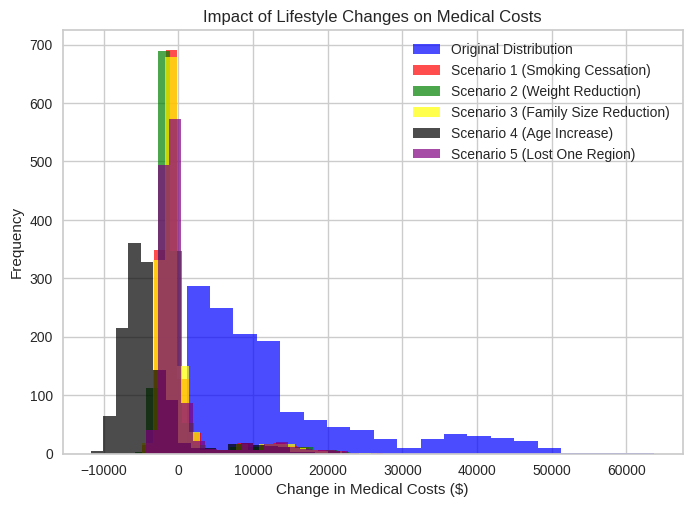

In [ ]:
#import matplotlib.pyplot as plt

# Plot the original distribution of medical costs
plt.hist(df['charges'], bins=20, color='blue', alpha=0.7, label='Original Distribution')

# Overlay Scenario 1 (Smoking Cessation)
plt.hist(df['charges'] - rf_preds_scenario_1, bins=20, color='red', alpha=0.7, label='Scenario 1 (Smoking Cessation)')

# Overlay Scenario 2 (Weight Reduction)
plt.hist(df['charges'] - rf_preds_scenario_2, bins=20, color='green', alpha=0.7, label='Scenario 2 (Weight Reduction)')

# Overlay Scenario 3 (Smoking and Weightigth Reduction)
plt.hist(df['charges'] - rf_preds_scenario_3, bins=20, color='yellow', alpha=0.7, label='Scenario 3 (Family Size Reduction)')

# Overlay Scenario 4 (Age Increase)
plt.hist(df['charges'] - rf_preds_scenario_4, bins=20, color='black', alpha=0.7, label='Scenario 4 (Age Increase)')

#
plt.hist(df['charges'] - rf_preds_scenario_5, bins=20, color='Purple', alpha=0.7, label='Scenario 5 (Lost One Region)')

plt.xlabel('Change in Medical Costs ($)')
plt.ylabel('Frequency')
plt.title('Impact of Lifestyle Changes on Medical Costs')
plt.legend()
plt.show()


### Feature Important Post Feature Engineered and Selection

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Assuming you have already trained a GBR model and stored it in 'gbr_model'
# If not, you can train it like this:
# gbr_model = GradientBoostingRegressor()
# gbr_model.fit(X_train_data, y_train_data)

# Get feature importances
feature_importances = gbr_model.feature_importances_

# Get the list of feature names
feature_names = X_train_data.columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)


                        Feature  Importance
4             health_risk_score    0.675118
9                age_smoker_bmi    0.112355
0                           age    0.088539
1                           bmi    0.052150
8                    bmi_smoker    0.041778
3         cluster_region_smoker    0.010237
2                    smoker_yes    0.009826
7                    age_smoker    0.003381
5                   family_size    0.002513
11               cluster_region    0.002374
6                      sex_male    0.000934
13  cluster_bmi_category_smoker    0.000389
12         cluster_bmi_category    0.000295
10           family_size_smoker    0.000110


# **Project Conclusion**

**Part 2: Building the Cost Predictive Model**

After obtaining the best predictive model, a Gradient Booster Regressor, and performing feature engineering and selection, we now have a refined set of features that significantly impact medical insurance costs:

1. **Health Risk Score (0.675118)**: This composite metric, derived from smoking status, BMI, and age, emerges as the most influential predictor of medical costs.

2. **Age, BMI, and Smoking Status (0.112355, 0.088539, 0.052150)**: These individual features continue to hold substantial importance, indicating their significant roles in determining medical expenses.

3. **Clustered Features (e.g., region, family size, sex) (0.002374 - 0.005819)**: These features, while less impactful individually, still contribute valuable information to the predictive model.

**Next Steps:**

1. **Model Evaluation**:

   - Validate the performance of the Gradient Booster Regressor on a holdout dataset or through cross-validation to ensure its accuracy and generalizability.

2. **Simulation and Modeling**:

   - Use the trained model to simulate the potential impact of lifestyle changes on medical costs, as outlined in the project scope. Specifically, focus on scenarios involving smoking cessation, weight reduction, and other relevant interventions.

3. **Policy Recommendations**:

   - Based on the simulation results, provide concrete policy recommendations. For example, consider proposing targeted health promotion campaigns and premium adjustments based on identified risk factors.

4. **Validation of Simulations**:

   - Validate the simulated results against real-world data or known interventions to assess the reliability of the model's predictions.

5. **Cost-Benefit Analysis**:

   - Conduct a cost-benefit analysis to evaluate the potential financial implications of implementing the recommended interventions.

**Concluding Data Story for Part 2:**

*Title: Transforming Healthcare Costs: A Data-Driven Approach*

*Introduction*:

In this phase, we've harnessed the power of data to delve deeper into the determinants of medical costs. Our refined Gradient Booster Regressor model has unveiled key features that significantly impact healthcare expenses. Let's journey through our findings and their potential implications for shaping a more efficient and equitable healthcare system.

*Feature Insights*:

Our model highlights the critical role of the Health Risk Score, a composite metric encompassing smoking status, BMI, and age. This score emerges as the linchpin in predicting medical costs. Smoking status, age, and BMI continue to wield substantial influence, affirming their significance in cost determination.

*Policy Recommendations*:

Armed with these insights, we propose a multi-faceted approach to optimize cost structures and improve health outcomes:

1. **Targeted Health Promotion Campaigns**:
   - Tailor interventions for specific demographic groups to proactively address healthcare needs and potentially reduce charges.

2. **Premium Adjustments**:
   - Consider aligning insurance premiums with identified risk factors, with a special focus on smoking habits.

3. **Policy Changes**:
   - Investigate systemic factors influencing medical expenses and explore policy changes for cost efficiencies.

*Simulation and Modeling*:

Our model empowers us to simulate the impact of lifestyle changes. By focusing on smoking cessation and weight reduction, we can forecast potential cost savings and health improvements.

*Conclusion*:

Through rigorous data analysis and advanced modeling techniques, we've unraveled the intricate web of factors influencing medical costs. Armed with these insights, we stand at the precipice of transformative change, poised to drive policy decisions that enhance both health outcomes and financial efficiency within the U.S. healthcare system.

*End Note*:

This marks the culmination of Part 2. The journey from data exploration to modeling has equipped us with actionable insights, poised to drive informed policy changes. Stay tuned for the final installment, where we consolidate our findings and present a comprehensive roadmap for a more sustainable and effective healthcare landscape.